In [1]:
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

plt.style.use("seaborn-v0_8")
import argparse
import logging
import os

from DA_PoC.common.observation_operator import (
    IdentityObservationOperator,
)  # RandomObservationOperator,; LinearObervationOperator,
from DA_PoC.dynamical_systems.lorenz_numerical_model import (
    LorenzWrapper,
    burn_model,
    create_lorenz_model_observation,
)
from DA_PoC.variational.incrementalCG import Incremental4DVarCG, pad_ragged

logging.basicConfig(level=logging.INFO)
logs_path = os.path.join(os.sep, "root", "log_dump", "smoke")
exp_path = os.path.join(os.sep, "home", "lorenz")
artifacts_path = os.path.join(exp_path, "artifacts")
plt.set_cmap("magma")

import torch
import yaml
import sys
sys.path.append('..')
from prec_models import construct_model_class
from prec_models.models_spectral import SVDConvolutional


rng = np.random.default_rng(seed=93)



/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpk4s0ofb1
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpk4s0ofb1/_remote_module_non_scriptable.py


<Figure size 800x550 with 0 Axes>

In [10]:

with open("/home/GNlearning/lorenz/artifacts/mlflow_run_id.yaml", "r") as fstream:
    run_id_yaml = yaml.safe_load(fstream)
    run_id = run_id_yaml["run_id"]
    data_path = run_id_yaml["data_path"]
    model_path = run_id_yaml["model_path"]
# "/home/data/data_data_assimilation/lorenz/tmp_model_storage/3c49c47492ef4b54a1431d661b89ea71/config.yaml"
# config = OmegaConf.load(
#     os.path.join(os.sep, *model_path.split("/")[:-1], "config.yaml")
# )
config = OmegaConf.load("/home/data/data_data_assimilation/lorenz/tmp_model_storage/3c49c47492ef4b54a1431d661b89ea71/config.yaml")
model_classes = {"SVDConvolutional": SVDConvolutional}
torch_model = construct_model_class(
    model_classes[config["architecture"]["class"]],
    rank=config["architecture"]["rank"],
)
state_dimension = config["model"]["dimension"]
loaded_model = torch_model(
    state_dimension=state_dimension, config=config["architecture"]
)

loaded_model.load_state_dict(torch.load(os.path.join(os.sep, 'home', *model_path.split('/'))))#{}, model_path)))
loaded_model.eval()

dummy(
  (layers): ConvLayersSVD(
    (dilations_layers): ParallelConv1DDilations(
      (conv_layers_dilations): ModuleList(
        (0): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (1): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,), bias=False, padding_mode=circular)
        (2): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,), bias=False, padding_mode=circular)
      )
    )
    (convlayers_vec): PeriodicConv1DBlock(
      (layers_vec): Sequential(
        (0): Conv1d(4, 95, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
        (1): BatchNorm1d(95, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv1d(95, 95, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
        (4): BatchNorm1d(95, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Lea

'/data/data_data_assimilation/lorenz/tmp_model_storage/3c49c47492ef4b54a1431d661b89ea71/model.pth'

In [ ]:

def main(config, n, loaded_model=None):
    if n is None:
        n = config["model"]["dimension"]
    window = 20
    lorenz = LorenzWrapper(n)
    x0_t = burn_model(lorenz, 1000)
    lorenz.n_total_obs = window

    m = n * (window + 1)
    lorenz.set_observations(window)
    lorenz.H = lambda x: x
    lorenz.background = np.zeros(n)
    lorenz.background_error_cov_inv = np.zeros((n,n))


    identity_obs_operator = IdentityObservationOperator(m)
    l_model_randobs = create_lorenz_model_observation(
        lorenz, identity_obs_operator, test_consistency=False
    )

    def get_next_obs(x0):
        return lorenz.get_next_observations(
            x0,
            model_error_sqrt=config["DA"]["model_error_sqrt"],
            obs_error_sqrt=config["DA"]["obs_error_sqrt"],
        )

    # obs, x_t, truth = get_next_obs(x0_t)

    n_cycle = config["DA"]["n_cycle"]  # 3
    n_outer = config["DA"]["n_outer"]  # 10
    n_inner = config["DA"]["n_inner"]  # 100
    log_file = config["DA"]["log_file"]


    DA_exp_dict = {}

    def create_DA_experiment(exp_name, prec):
        DA_exp = Incremental4DVarCG(
            state_dimension=n,
            bounds=None,
            numerical_model=l_model_randobs,
            observation_operator=identity_obs_operator,
            x0_run=x0_t,
            x0_analysis=None,
            get_next_observations=get_next_obs,
            n_cycle=n_cycle,
            n_outer=n_outer,
            n_inner=n_inner,
            prec=prec,
            plot=False,
            log_append=False,
            save_all=True,
        )
        DA_exp.GNlog_file = log_file
        DA_exp.exp_name = exp_name
        DA_exp_dict[exp_name] = DA_exp
        return DA_exp

    DA_baseline = create_DA_experiment("baseline", prec=None)

    for exp_name, DA_exp in DA_exp_dict.items():
        print(f"\n--- {exp_name} ---\n")
        DA_exp.run()

    for i, (exp_name, DA_exp) in enumerate(DA_exp_dict.items()):
        DA_exp.plot_residuals_inner_loop(
            f"C{i}", label=DA_exp.exp_name, cumulative=False
        )
    plt.legend()
    plt.ylim([1e-9, 1e2])
    plt.show()
    return DA_exp_dict



In [2]:
config = OmegaConf.load("config.yaml")
config['DA']['model_error_sqrt'] = 1.0
config['DA']['obs_error_sqrt'] = 1.0
config['model']['dim'] = 20
print(config['DA'])

{'n_cycle': 10, 'n_outer': 5, 'n_inner': 100, 'model_error_sqrt': 1.0, 'obs_error_sqrt': 1.0, 'log_file': '/GNlearning/lorenz/artifacts/DA_logs.csv'}


In [ ]:
DA_exp_dict = main(config=config, n=20)

Observation operator set already
lorenz.cost_function(x0_t)=3394.905083287777
numerical_model_lorenz.cost_function(x0_t)=3394.905083287777

--- baseline ---

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     0,     0, 3383.3364,       24,  59.24, 1.082e+02, 1.082e+02
baseline,     0,     1, 1962.9944,       24,  59.22, 1.155e+02, 1.155e+02
baseline,     0,     2, 1161.3062,       24,  60.25, 1.764e+02, 1.764e+02
baseline,     0,     3, 991.0006,       25,  61.16, 1.951e+02, 1.951e+02
baseline,     0,     4, 960.8994,       25,  61.29, 1.880e+02, 1.880e+02
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     1,     0, 8819.3027,       26,  60.37, 8.709e+01, 8.709e+01
baseline,     1,     1, 5461.2497,       28,  60.93, 1.877e+02, 1.877e+02
baseline,     1,     2, 4318.1881,       30,  64.20, 5.766e+02, 5.766e+02
baseline,     1,     3, 2146.7682,       30,  63.89, 9.041e+02, 9.041e+02
baseline,     1,     4, 3288.242

In [ ]:
baseline = DA_exp_dict["baseline"]

In [ ]:
for k, val in baseline.run_summary.items():
    try:
        print(f"{k}, {val.shape}")
    except AttributeError:
        try:
            print(f"{k}, {type(val)}, {len(val)}")
        except TypeError:
            print(f"{k}, {type(val)}")

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(baseline.run_summary['truth_full'])
plt.subplot(1, 3, 2)
plt.imshow(baseline.run_summary['analysis_full'])
plt.subplot(1, 3, 3)
plt.imshow((baseline.run_summary['truth_full'] - baseline.run_summary['analysis_full'])**2)


In [ ]:
n = 40
window = 10
lorenz = LorenzWrapper(n)
x0_t = burn_model(lorenz, 1000)
lorenz.n_total_obs = window

m = n * (window + 1)
lorenz.background_error_cov_inv = np.zeros((n, n))
lorenz.background = np.zeros(n)
lorenz.set_observations(nobs=window)
lorenz.H = lambda x: x

identity_obs_operator = IdentityObservationOperator(m)
l_model_randobs = create_lorenz_model_observation(
    lorenz, identity_obs_operator, test_consistency=False
)

def get_next_obs(x0):
    return lorenz.get_next_observations(
        x0,
        model_error_sqrt=config["DA"]["model_error_sqrt"],
        obs_error_sqrt=config["DA"]["obs_error_sqrt"],
    )
obs, x_t, truth = get_next_obs(np.random.normal(size=n))
truth = truth[:, 1:]

# self.numerical_model.set_obs(self.observation_operator(obs.reshape(-1)))

In [ ]:
n_cycle = 5
n_outer = 5
n_inner = 20
x0_t = burn_model(lorenz, 1000)

In [ ]:
DA_exp = Incremental4DVarCG(
    state_dimension=n,
    bounds=None,
    numerical_model=l_model_randobs,
    observation_operator=identity_obs_operator,
    x0_run=x0_t,
    x0_analysis=None,
    get_next_observations=get_next_obs,
    n_cycle=n_cycle,
    n_outer=n_outer,
    n_inner=n_inner,
    prec=None,
    plot=False,
    log_append=True,
    save_all=True,
)
DA_exp.run('baseline')

In [ ]:
from DA_PoC.common.linearsolver import solve_cg, conjGrad
from DA_PoC.common.preconditioned_solvers import PreconditionedSolver


# class PreconditionedSolver:
#     def __init__(self, tol: float = 1e-8, maxiter: int = 100):
#         self.tol = tol
#         self.maxiter = maxiter

#     def __call__(
#         self, A: np.ndarray, b: np.ndarray, x: np.ndarray, maxiter: int = None
#     ):
#         if maxiter is not None:
#             self.maxiter = maxiter
#         return conjGrad(A, x, b, tol=self.tol, maxiter=self.maxiter)


class PseudoInverseStart(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank

    def __call__(self, A, b, x, maxiter):
        U, S, Vt = np.linalg.svd(A)
        A_dagger = U[:, :self.rank] @ (S[:self.rank]**(-1) * U[:, :self.rank]).T
        return conjGrad(A, A_dagger @ b, b, tol=self.tol, maxiter=self.maxiter, verbose=False)


class BalancingPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank

    def __call__(self, A, b, x, maxiter):
        U, S, Vt = np.linalg.svd(A)
        A_dagger = U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
        return conjGrad(A_dagger @ A, 0*b, A_dagger @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)

    def get_prec(self, A):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
    
    def power_inv(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


class SplitPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank
    
    def power_prec(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


    def __call__(self, A, b, x, maxiter):
        L = self.power_prec(A, power=-0.5)
        # Linv = self.power_prec(A, power=0.5)
        x_hat, res_dict = conjGrad(L.T @ A @ L, 0*b, L.T @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)
        return L @ x_hat, res_dict


# A_ = np.random.normal(size=(20, 20))
# A = A_.T @ A_
# L = BalancingPrec(rank=10).power_inv(A, power=-0.5)
# print(L.T @ A @L)
# plt.plot(np.linalg.eigvalsh(L.T @ A @ L))
# plt.plot(np.linalg.eigvalsh(A))

# L2 = BalancingPrec(rank=10).power_inv(A, power=0.5)
# L @ L2

# np.linalg.

In [ ]:
DA_exp.plot_residuals_inner_loop("C0")

for i, rank in enumerate([5, 10, 20, 25, 30 ,35, 39]):
    DA_pse = Incremental4DVarCG(
        state_dimension=n,
        bounds=None,
        numerical_model=l_model_randobs,
        observation_operator=identity_obs_operator,
        x0_run=x0_t,
        x0_analysis=None,
        get_next_observations=get_next_obs,
        n_cycle=n_cycle,
        n_outer=n_outer,
        n_inner=n_inner,
        prec=PseudoInverseStart(rank=rank, maxiter=n_inner),
        plot=False,
        log_append=True,
        save_all=True,
    )
    DA_pse.run(f'pse {i}')
    DA_pse.plot_residuals_inner_loop(f"C{i+1}", label=f'{rank}')

plt.legend()

In [ ]:
class BalancingPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank

    def __call__(self, A, b, x, maxiter):
        U, S, Vt = np.linalg.svd(A)
        A_dagger = U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
        return conjGrad(A_dagger @ A, 0*b, A_dagger @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)

    def get_prec(self, A):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
    
    def power_inv(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


class SplitPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank
    
    def power_prec(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


    def __call__(self, A, b, x, maxiter):
        L = self.power_prec(A, power=-0.5)
        # Linv = self.power_prec(A, power=0.5)
        x_hat, res_dict = conjGrad(L.T @ A @ L, 0*b, L.T @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)
        return L @ x_hat, res_dict

A_ = np.random.normal(size=(20, 20))
A = A_.T @ A_
x = np.arange(20)
SplitPrec()(A, A@x, None, None)
# A_ = np.random.normal(size=(20, 20))
# A = A_.T @ A_
# L = BalancingPrec(rank=10).power_inv(A, power=-0.5)
# print(L.T @ A @L)
# plt.plot(np.linalg.eigvalsh(L.T @ A @ L))
# plt.plot(np.linalg.eigvalsh(A))

# L2 = BalancingPrec(rank=10).power_inv(A, power=0.5)
# L @ L2

# np.linalg.

In [ ]:
DA_exp.plot_residuals_inner_loop("C0")

for i, rank in enumerate([5, 10, 20, 25, 30 ,35, 39]):
    DA_bal = Incremental4DVarCG(
        state_dimension=n,
        bounds=None,
        numerical_model=l_model_randobs,
        observation_operator=identity_obs_operator,
        x0_run=x0_t,
        x0_analysis=None,
        get_next_observations=get_next_obs,
        n_cycle=n_cycle,
        n_outer=n_outer,
        n_inner=n_inner,
        prec=BalancingPrec(rank=rank, maxiter=n_inner),
        plot=False,
        log_append=True,
        save_all=True,
    )
    DA_bal.run(f'pse {i}')
    DA_bal.plot_residuals_inner_loop(f"C{i+1}", label=f'{rank}')

plt.legend()

In [ ]:
DA_exp.plot_residuals_inner_loop("C0")
for i, rank in enumerate([5, 10, 20, 25, 30 ,35, 39]):
    DA_spli = Incremental4DVarCG(
        state_dimension=n,
        bounds=None,
        numerical_model=l_model_randobs,
        observation_operator=identity_obs_operator,
        x0_run=x0_t,
        x0_analysis=None,
        get_next_observations=get_next_obs,
        n_cycle=n_cycle*2,
        n_outer=n_outer*2,
        n_inner=n_inner,
        prec=SplitPrec(rank=rank, maxiter=n_inner),
        plot=False,
        log_append=True,
        save_all=True,
    )
    DA_spli.run(f'pse {i}')
    DA_spli.plot_residuals_inner_loop(f"C{i+1}", label=f'{rank}')


In [3]:
import sys
sys.path.append('..')

import mlflow
logged_model = f"runs:/1fc099175a1946da9db33fe34722a63b/smoke_model"
mlflow.pyfunc.get_model_dependencies(logged_model)
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(f"{loaded_model=}")
# except:
# loaded_model = None



def construct_svd_ML(loaded_model, x_, qr=True):
    pred = loaded_model.predict(np.asarray(x_).astype("f"))
    Ur, logsvals = pred[:, :-1, :], pred[:, -1, :]
    Sr = np.exp(logsvals)
    if qr:
        Ur = np.linalg.qr(Ur)[0]
    return Sr.squeeze(), Ur.squeeze()


/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


MlflowException: Run '1fc099175a1946da9db33fe34722a63b' not found

In [ ]:
state = DA_spli.run_summary['truth_full'][:, -1]
GN_mat = l_model_randobs.gauss_newton_hessian_matrix(state)
plt.imshow(GN_mat)

In [ ]:
Sr, Ur = construct_svd_ML(loaded_model, x_=state.reshape(1, 40))
Ur.shape

In [ ]:
GN_ml = Ur @ (Sr[None, :] * Ur).T

In [ ]:
plt.imshow(GN_mat)
plt.colorbar()
plt.figure()
plt.imshow(GN_ml)
plt.colorbar()
plt.figure()
plt.imshow(GN_mat - GN_ml)
plt.colorbar()

In [ ]:
U, S, _ = np.linalg.svd(GN_mat)

In [ ]:
plt.plot(S)
plt.plot(np.sort(Sr)[::-1])

In [7]:
import pandas as pd, seaborn as sns

In [8]:
df = pd.DataFrame([{"intercept": 4.43, "slope": -0.56, "name": "baseline"},
              {"intercept": 4.43, "slope": -0.46, "name": "ML"}])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='name', ylabel='intercept'>

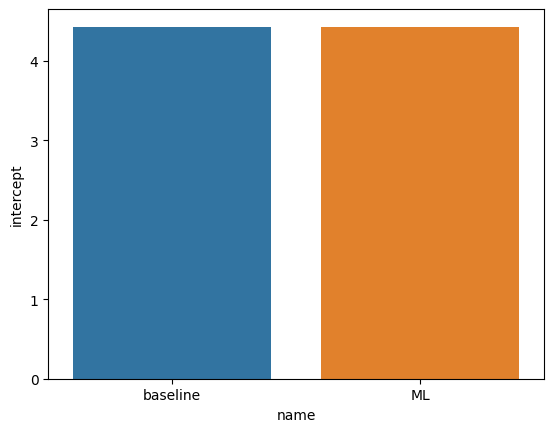

In [13]:
sns.barplot(df, y='intercept', x='name')